## Exercise 4
The purpose of this exercise is to insert dispersion suppressors into the existing regular lattice.

Start with the lattice from the previous exercise and first double the circumference to 2000 m. Change the phase advance to $\phi=60^\circ$ per cell. 

Insert two straight sections (each of 2 cells): i.e., cells without bending magnets but keep the same focusing of the quadrupoles. Insert the two straight sections opposite in azimuth in the ring. Modify now the lattice to keep the horizontal dispersion function small ($<1$-$2$ m) along this straight section, i.e. set up a dispersion suppressor. You can do this by adding or removing bending magnets or changing the bending radius of some or all the bending magnets.
At this stage do not change the focusing properties in any of the cells. Such straight sections with very small dispersion are very useful for the installation of RF equipment, wigglers, undulators, beam instrumentation, collimation systems etc., or to house an experiment.
As a second exercise, replace all bending magnets presently implemented as thin lenses, by thick lenses, i.e. define them as SBEND with the same angle. Look at the result and explain what you observe.

One can analyze the problem using the approach presented in the lecture 
https://cernbox.cern.ch/index.php/s/LBXCo5iPDazggkD


---

**The missing dipoles approach**

Fix
\begin{equation}
\mu_{cell}=\frac{2 k+1}{2 m+n} \pi
\end{equation}
where $k\in\{0,1,\dots\}$, $m$ is the number of regular cells between the Interaction Point and the arc and $n$ is the number of missing-dipole cells.

---
**The half-dipoles approach**

Using a similar approach, we can reduce the bending strength of the dipoles in some specific FODO cells to suppress dispersion.

\begin{equation}
\sin^2 \left(\frac{n \mu_{cell}}{2}\right)=\frac{r}{2}
\end{equation}

where $n$ is the number of cells where the dipole strenght is $r$-times weaker than the one in the regular arc cells ($r>1$) and, as usual, $\mu_{cell}$ is the cell phase advance.

In the exercise it was requested a 60 deg phase advance, therefore you can reach it with
- missing dipole: k=0, m=1, n=1.
- half dipole: r=2, n=3.


In [2]:
from cpymad.madx import Madx
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib','inline')
%config InlineBackend.figure_format = 'retina' # retina display
import matplotlib.patches as patches


def plotLatticeSeries(ax,series, height=1., v_offset=0., color='r',alpha=0.5,lw=3):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return;

### First step: make a sequence of 2000 m and double the number of cells.

In [4]:
madx = Madx(stdout=False)

madx.input('''
TITLE, ’CAS Fourth Exercise’; 

circum=2000.0;
ncell = 40; !Number of cells 
lcell = circum/ncell;
lq = 3.00; !Length of a quadrupole

!element definitions;
!define bending magnet as multipole 
!we have 4 bending magnets per cell
mb:multipole,knl={2.0*pi/(4*ncell)};

!define quadrupoles as multipoles 
qf: multipole,knl={0,0.0098*lq}; 
qd: multipole,knl={0,-0.0098*lq};

// define the sextupoles as multipole
lsex = 0.00001; // dummy length, only used in the sequence;

// ATTENTION: must use knl:= and NOT knl= to match later ! 
msf: multipole, knl:={0,0,ksf};
msd: multipole, knl:={0,0,ksd};

!sequence declaration;
cas4: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
   n = 1;
   while (n < ncell+1) {
    qf: qf,   at=(n-1)*lcell;
    msf: msf, at=(n-1)*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.15*lcell;
    mb: mb,   at=(n-1)*lcell + 0.35*lcell;
    qd: qd,   at=(n-1)*lcell + 0.50*lcell;
    msd: msd, at=(n-1)*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=(n-1)*lcell + 0.65*lcell;
    mb: mb,   at=(n-1)*lcell + 0.85*lcell;
    at=(n-1)*lcell;
    n = n + 1;
}
end_machine: marker at=circum;
endsequence;

!define the beam and its properties
Beam, particle = proton, sequence=cas4, energy = 20.0;

use, sequence=cas4;

ksf=0;
ksd=0;

!execute the TWISS command 
twiss;
''')

True

(-5.0, 20.0)

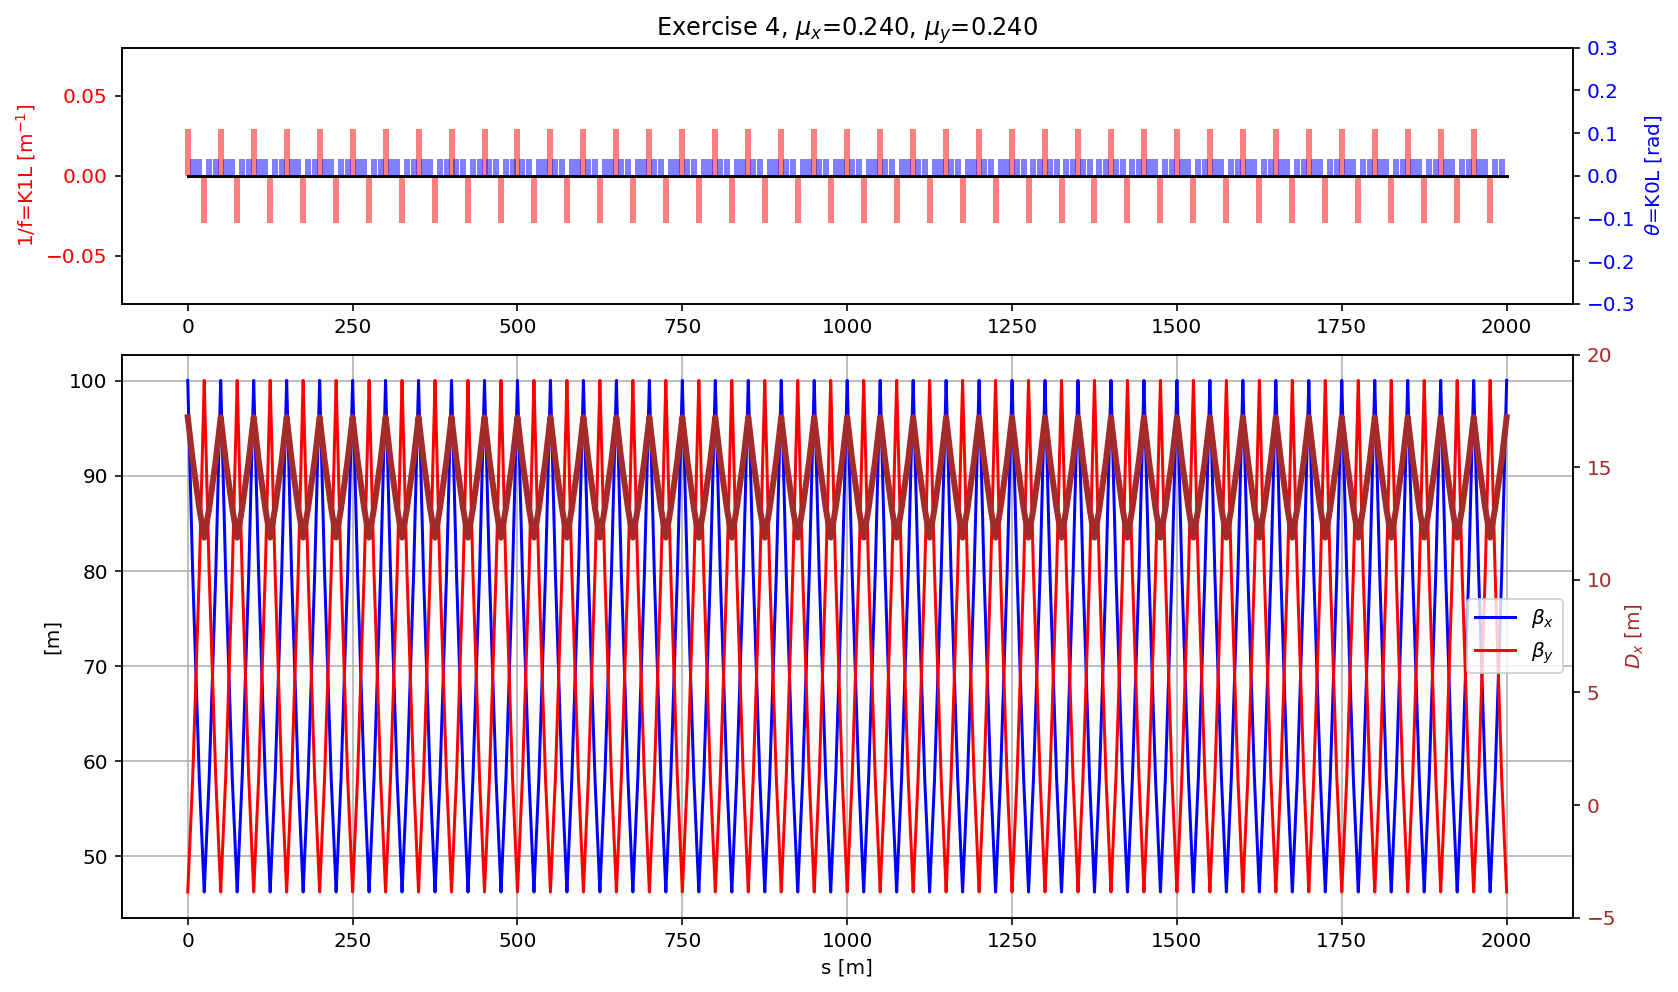

In [5]:
myTwiss=madx.table.twiss.dframe()
fig = plt.figure(figsize=(13,8))
# set up subplot grid
#gridspec.GridSpec(3,3)

ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

    
color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.08,.08)
plt.title('Exercise 4, $\\mu_x$='+format(madx.table.summ.Q1[0]/20,'2.3f')+', $\\mu_y$='+ format(madx.table.summ.Q2[0]/20,'2.3f'))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)


#DF=myTwiss[(myTwiss['keyword']=='sbend')]
#for i in range(len(DF)):
#    aux=DF.iloc[i]
#    plotLatticeSeries(ax2,aux, height=aux.angle*1000, v_offset=aux.angle*1000/2, color='b')

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k0l, v_offset=aux.k0l/2, color='b')

plt.ylim(-.3,.3)

# large subplot
plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$', lw=3)
ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(-5, 20)

#### Survey sanity check

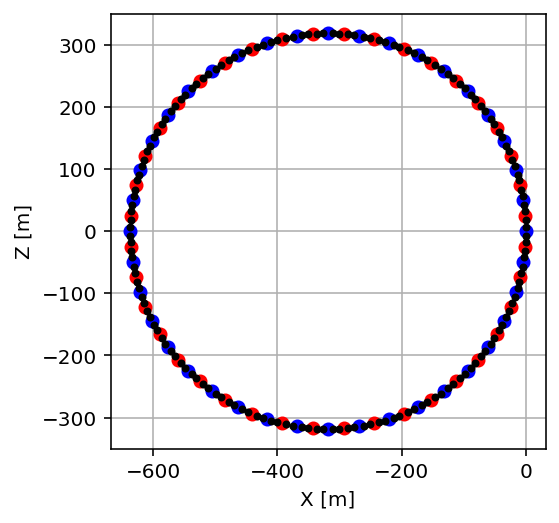

In [6]:
madx.input('survey')
mySurvey=madx.table.survey.dframe()
qfSurvey=mySurvey[mySurvey['name'].str.contains('qf')]
qdSurvey=mySurvey[mySurvey['name'].str.contains('qd')]
mbSurvey=mySurvey[mySurvey['name'].str.contains('mb')]

plt.plot(qfSurvey.x,qfSurvey.z,'ob')
plt.plot(qdSurvey.x,qdSurvey.z,'or')
plt.plot(mbSurvey.x,mbSurvey.z,'.k')

plt.axis('square');
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.grid()

### Second step : modify the sequence to create the space of the straight sections

In [7]:
madx=Madx()
madx.input('''
TITLE, ’CAS Fourth Exercise’; 

circum=2000.0;
ncell = 40; !Number of cells 
lcell = circum/ncell;
lq = 3.00; !Length of a quadrupole

nnorm=128;

!element definitions;

!define bending magnet as multipole 
!we have 4 bending magnets per cell

mb:multipole,knl={2.0*pi/(nnorm)};
!mb:SBEND, L=5,ANGLE=2.0*pi/(nnorm);

!define quadrupoles as multipoles 

kqf:=0.0098;
kqd:=-0.0098;
qf: multipole,knl:={0,kqf*lq}; 
qd: multipole,knl:={0,kqd*lq};

// define the sextupoles as multipole
lsex = 0.00001; // dummy length, only used in the sequence; i


ksf := +0.017041/ncell;
ksd := -0.024714/ncell;

// ATTENTION: must use knl:= and NOT knl= to match later ! 
msf: multipole, knl:={0,0,ksf};
msd: multipole, knl:={0,0,ksd};


!sequence declaration;
cas4: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
 
   n = 0;
   while (n < 4) {
    qf: qf,   at=n*lcell;
    msf: msf, at=n*lcell + lsex/2.0;
    mb: mb,   at=n*lcell + 0.15*lcell;
    mb: mb,   at=n*lcell + 0.35*lcell;
    qd: qd,   at=n*lcell + 0.50*lcell;
    msd: msd, at=n*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=n*lcell + 0.65*lcell;
    mb: mb,   at=n*lcell + 0.85*lcell;
    n = n + 1;
}

! *************************
! START dispersion suppressor
    qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
    n = n + 1;

        qf: qf,   at=n*lcell;
        mb: mb,   at=n*lcell + 0.15*lcell;
    mb: mb,   at=n*lcell + 0.35*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        mb: mb,   at=n*lcell + 0.65*lcell;
        mb: mb,   at=n*lcell + 0.85*lcell;
    n = n + 1;
! END dispersion suppressor

myStart: marker, at=n*lcell;
! *************************
! START straight section
        qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
    n = n + 1;

        qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
    n = n + 1;
! END straight section

! *************************
! START dispersion suppressor
        qf: qf,   at=n*lcell;
        mb: mb,   at=n*lcell + 0.15*lcell;
    mb: mb,   at=n*lcell + 0.35*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        mb: mb,   at=n*lcell + 0.65*lcell;
        mb: mb,   at=n*lcell + 0.85*lcell;
    n = n + 1;
    
    qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
    n = n + 1;
! END dispersion suppressor
   
   while (n < 24) {
    qf: qf,   at=n*lcell;
    msf: msf, at=n*lcell + lsex/2.0;
    mb: mb,   at=n*lcell + 0.15*lcell;
    mb: mb,   at=n*lcell + 0.35*lcell;
    qd: qd,   at=n*lcell + 0.50*lcell;
    msd: msd, at=n*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=n*lcell + 0.65*lcell;
    mb: mb,   at=n*lcell + 0.85*lcell;
    n = n + 1;
}

! *************************
! START dispersion suppressor
        qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        n = n + 1;

        qf: qf,   at=n*lcell;
        mb: mb,   at=n*lcell + 0.15*lcell;
        mb: mb,   at=n*lcell + 0.35*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        mb: mb,   at=n*lcell + 0.65*lcell;
        mb: mb,   at=n*lcell + 0.85*lcell;
        n = n + 1;
! END dispersion suppressor

! *************************
! START straight section
        qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        n = n + 1;

        qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        n = n + 1;
! END straight section

! *************************
! START dispersion suppressor
        qf: qf,   at=n*lcell;
        mb: mb,   at=n*lcell + 0.15*lcell;
        mb: mb,   at=n*lcell + 0.35*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        mb: mb,   at=n*lcell + 0.65*lcell;
        mb: mb,   at=n*lcell + 0.85*lcell;
        n = n + 1;

        qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        n = n + 1;
! END dispersion suppressor

   while (n < ncell) {
        qf: qf,   at=n*lcell;
        msf: msf, at=n*lcell + lsex/2.0;
        mb: mb,   at=n*lcell + 0.15*lcell;
        mb: mb,   at=n*lcell + 0.35*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        msd: msd, at=n*lcell + 0.50*lcell + lsex/2.0;
        mb: mb,   at=n*lcell + 0.65*lcell;
        mb: mb,   at=n*lcell + 0.85*lcell;
        n = n + 1;
}

end_machine: marker at=circum;
endsequence;

!define the beam and its properties

Beam, particle = proton, sequence=cas4, energy = 20.0;

!define the desired output

use, sequence=cas4;
select,flag=twiss,column=name,s,x,y,mux,betx, muy,bety,dx,dy;

!Tune matching

match, sequence=cas4;
  vary,name=kqf, step=0.00001;
  vary,name=kqd, step=0.00001;
  global,sequence=cas4,Q1=ncell/6;
  global,sequence=cas4,Q2=ncell/6;
  Lmdif, calls=10, tolerance=1.0e-21;
endmatch;

! Chromaticity matching
!match, sequence=cas4;
!  vary,name=ksf, step=0.00001;
!  vary,name=ksd, step=0.00001;
!  global,sequence=cascell1,DQ1=0.0;
!  global,sequence=cascell1,DQ2=0.0;
!  Lmdif, calls=10, tolerance=1.0e-21;
!endmatch;

!execute the TWISS command 
twiss;
''');


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2022.11.10 16:39:14      +
  ++++++++++++++++++++++++++++++++++++++++++++
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n redefined
++++++ info: n re

(-5, 20)

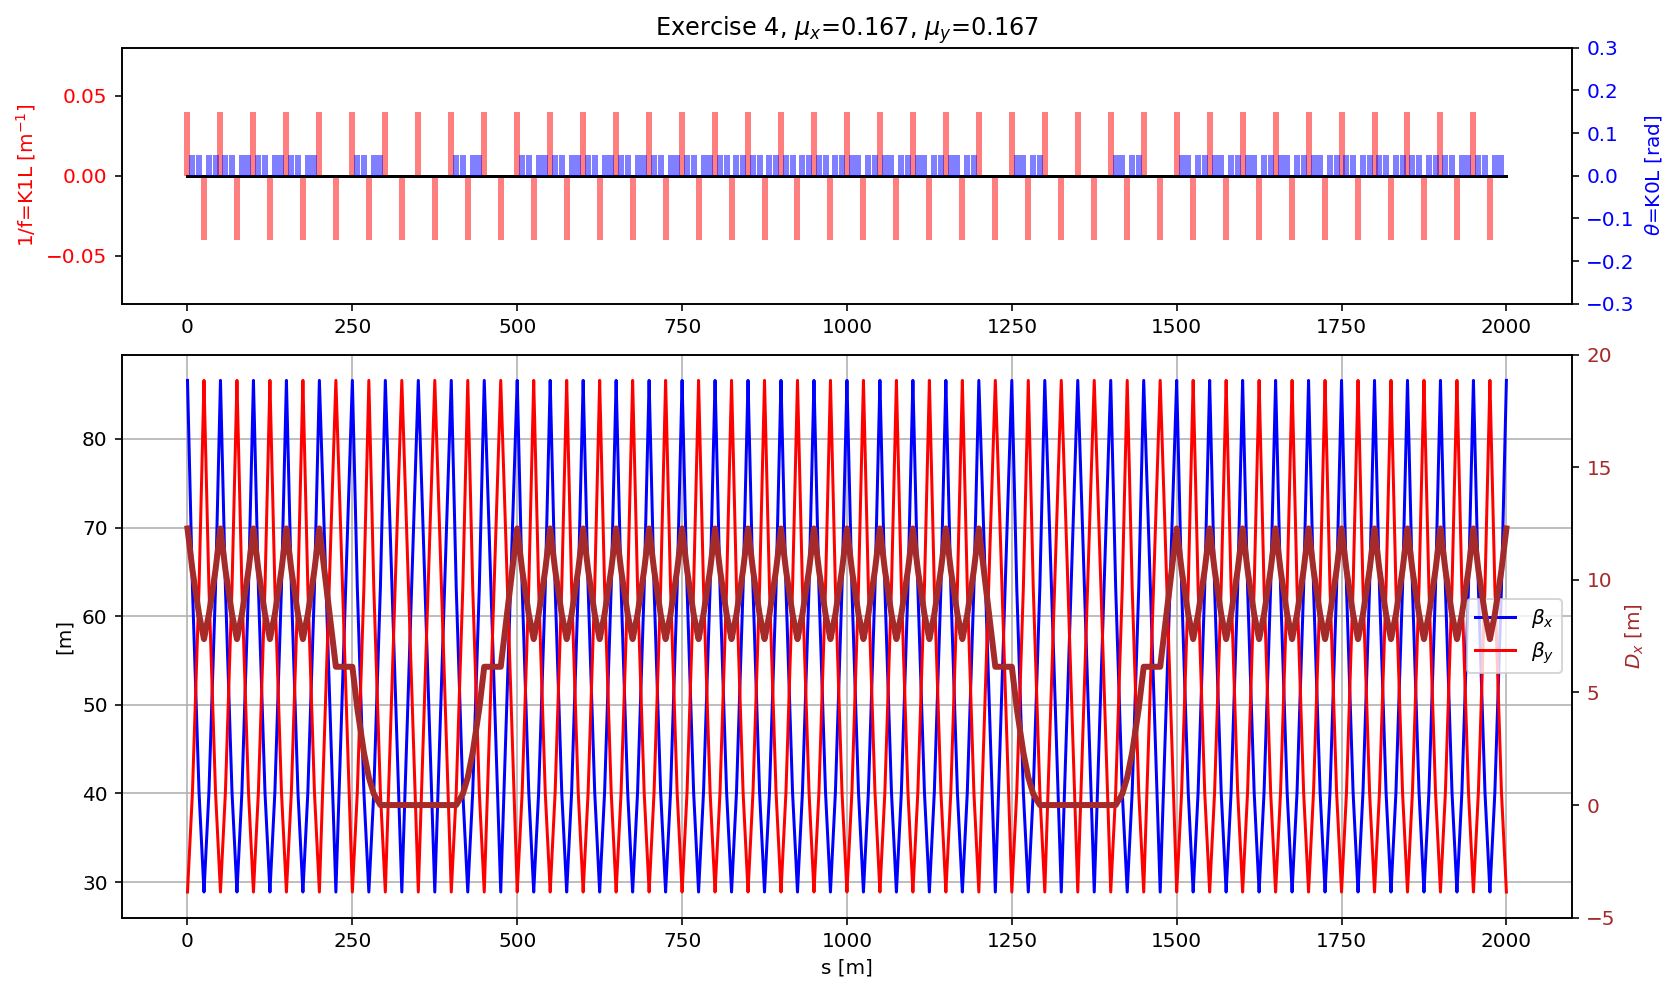

In [24]:
myTwiss=madx.table.twiss.dframe()
fig = plt.figure(figsize=(13,8))

ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.08,.08)
plt.title('Exercise 4, $\\mu_x$='+format(madx.table.summ.Q1[0]/40,'2.3f')+', $\\mu_y$='+ format(madx.table.summ.Q2[0]/40,'2.3f'))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k0l, v_offset=aux.k0l/2, color='b')
    
DF=myTwiss[(myTwiss['keyword']=='sbend')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='b')

plt.ylim(-.3,.3)

# large subplot
plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$', lw=3)
ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(-5, 20)

#### Survey sanity check

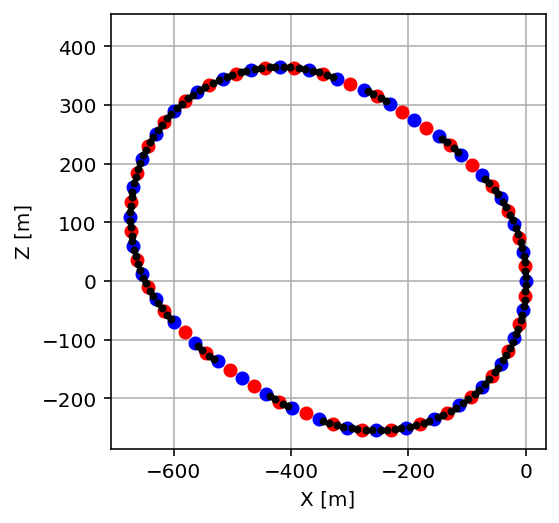

In [8]:
madx.input('survey')
mySurvey=madx.table.survey.dframe()
qfSurvey=mySurvey[mySurvey['name'].str.contains('qf')]
qdSurvey=mySurvey[mySurvey['name'].str.contains('qd')]
mbSurvey=mySurvey[mySurvey['name'].str.contains('mb')]

plt.plot(qfSurvey.x,qfSurvey.z,'ob')
plt.plot(qdSurvey.x,qdSurvey.z,'or')
plt.plot(mbSurvey.x,mbSurvey.z,'.k')

plt.axis('square');
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.grid()

One can use more evoluted environment to modify a sequence using the **seqedit** environment (http://mad.web.cern.ch/mad/webguide/manual.html#Ch8).
You can cycle, mirror,...sequences or remove, move, install...element.

For instance one can obtain the machine in Step 2, starting from the machine in Step 1 and removing elements (dipoles). All the examples in https://cernbox.cern.ch/index.php/s/LBXCo5iPDazggkD show this approach.

In [9]:
madx.input('''
seqedit, sequence=cas4;
flatten;
cycle, start=myStart; 
flatten;
endedit;
use, sequence=cas4;
''')

++++++ info: seqedit - number of elements installed:  0
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:    0
++++++ info: seqedit - number of elements replaced:   0


True

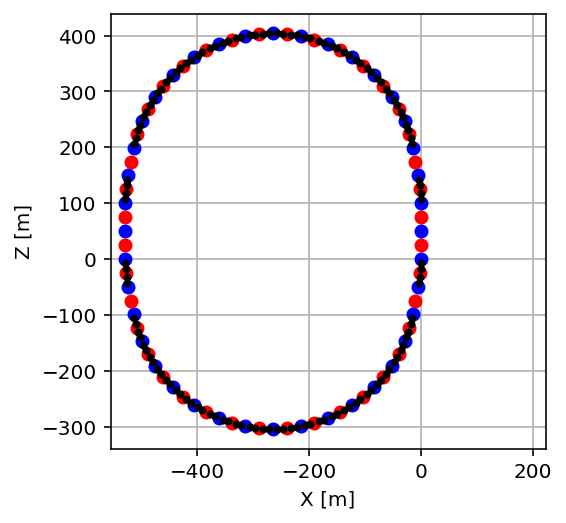

In [10]:
madx.input('survey')
mySurvey=madx.table.survey.dframe()
qfSurvey=mySurvey[mySurvey['name'].str.contains('qf')]
qdSurvey=mySurvey[mySurvey['name'].str.contains('qd')]
mbSurvey=mySurvey[mySurvey['name'].str.contains('mb')]

plt.plot(qfSurvey.x,qfSurvey.z,'ob')
plt.plot(qdSurvey.x,qdSurvey.z,'or')
plt.plot(mbSurvey.x,mbSurvey.z,'.k')

plt.axis('square');
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.grid()

### Replacing the thin lens dipole with sbend

In [12]:
madx=Madx(stdout=False)
madx.input('''
TITLE, ’CAS Fourth Exercise’; 

circum=2000.0;
ncell = 40; !Number of cells 
lcell = circum/ncell;
lq = 3.00; !Length of a quadrupole

nnorm=128;

!element definitions;

!define bending magnet as multipole 
!we have 4 bending magnets per cell

!mb:multipole,knl={2.0*pi/(nnorm)};
mb:SBEND, L=5,ANGLE=2.0*pi/(nnorm);

!define quadrupoles as multipoles 

kqf:=0.0098;
kqd:=-0.0098;
qf: multipole,knl:={0,kqf*lq}; 
qd: multipole,knl:={0,kqd*lq};

// define the sextupoles as multipole
lsex = 0.00001; // dummy length, only used in the sequence; i


ksf := +0.017041/ncell;
ksd := -0.024714/ncell;

// ATTENTION: must use knl:= and NOT knl= to match later ! 
msf: multipole, knl:={0,0,ksf};
msd: multipole, knl:={0,0,ksd};


!sequence declaration;
cas4: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
 
   n = 0;
   while (n < 4) {
    qf: qf,   at=n*lcell;
    msf: msf, at=n*lcell + lsex/2.0;
    mb: mb,   at=n*lcell + 0.15*lcell;
    mb: mb,   at=n*lcell + 0.35*lcell;
    qd: qd,   at=n*lcell + 0.50*lcell;
    msd: msd, at=n*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=n*lcell + 0.65*lcell;
    mb: mb,   at=n*lcell + 0.85*lcell;
    n = n + 1;
}

! *************************
! START dispersion suppressor
    qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
    n = n + 1;

        qf: qf,   at=n*lcell;
        mb: mb,   at=n*lcell + 0.15*lcell;
    mb: mb,   at=n*lcell + 0.35*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        mb: mb,   at=n*lcell + 0.65*lcell;
        mb: mb,   at=n*lcell + 0.85*lcell;
    n = n + 1;
! END dispersion suppressor

! *************************
! START straight section
        qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
    n = n + 1;

        qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
    n = n + 1;
! END straight section

! *************************
! START dispersion suppressor
        qf: qf,   at=n*lcell;
        mb: mb,   at=n*lcell + 0.15*lcell;
    mb: mb,   at=n*lcell + 0.35*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        mb: mb,   at=n*lcell + 0.65*lcell;
        mb: mb,   at=n*lcell + 0.85*lcell;
    n = n + 1;
    
    qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
    n = n + 1;
! END dispersion suppressor
   
   while (n < 24) {
    qf: qf,   at=n*lcell;
    msf: msf, at=n*lcell + lsex/2.0;
    mb: mb,   at=n*lcell + 0.15*lcell;
    mb: mb,   at=n*lcell + 0.35*lcell;
    qd: qd,   at=n*lcell + 0.50*lcell;
    msd: msd, at=n*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=n*lcell + 0.65*lcell;
    mb: mb,   at=n*lcell + 0.85*lcell;
    n = n + 1;
}

! *************************
! START dispersion suppressor
        qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        n = n + 1;

        qf: qf,   at=n*lcell;
        mb: mb,   at=n*lcell + 0.15*lcell;
        mb: mb,   at=n*lcell + 0.35*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        mb: mb,   at=n*lcell + 0.65*lcell;
        mb: mb,   at=n*lcell + 0.85*lcell;
        n = n + 1;
! END dispersion suppressor

! *************************
! START straight section
        qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        n = n + 1;

        qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        n = n + 1;
! END straight section

! *************************
! START dispersion suppressor
        qf: qf,   at=n*lcell;
        mb: mb,   at=n*lcell + 0.15*lcell;
        mb: mb,   at=n*lcell + 0.35*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        mb: mb,   at=n*lcell + 0.65*lcell;
        mb: mb,   at=n*lcell + 0.85*lcell;
        n = n + 1;

        qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        n = n + 1;
! END dispersion suppressor

   while (n < ncell) {
        qf: qf,   at=n*lcell;
        msf: msf, at=n*lcell + lsex/2.0;
        mb: mb,   at=n*lcell + 0.15*lcell;
        mb: mb,   at=n*lcell + 0.35*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        msd: msd, at=n*lcell + 0.50*lcell + lsex/2.0;
        mb: mb,   at=n*lcell + 0.65*lcell;
        mb: mb,   at=n*lcell + 0.85*lcell;
        n = n + 1;
}

end_machine: marker at=circum;
endsequence;

!define the beam and its properties

Beam, particle = proton, sequence=cas4, energy = 20.0;

!define the desired output

use, sequence=cas4;
select,flag=twiss,column=name,s,x,y,mux,betx, muy,bety,dx,dy;

!Tune matching

match, sequence=cas4;
  vary,name=kqf, step=0.00001;
  vary,name=kqd, step=0.00001;
  global,sequence=cas4,Q1=ncell/6;
  global,sequence=cas4,Q2=ncell/6;
  Lmdif, calls=10, tolerance=1.0e-21;
endmatch;

! Chromaticity matching
!match, sequence=cas4;
!  vary,name=ksf, step=0.00001;
!  vary,name=ksd, step=0.00001;
!  global,sequence=cascell1,DQ1=0.0;
!  global,sequence=cascell1,DQ2=0.0;
!  Lmdif, calls=10, tolerance=1.0e-21;
!endmatch;

!execute the TWISS command 
twiss;
''');

(-5, 20)

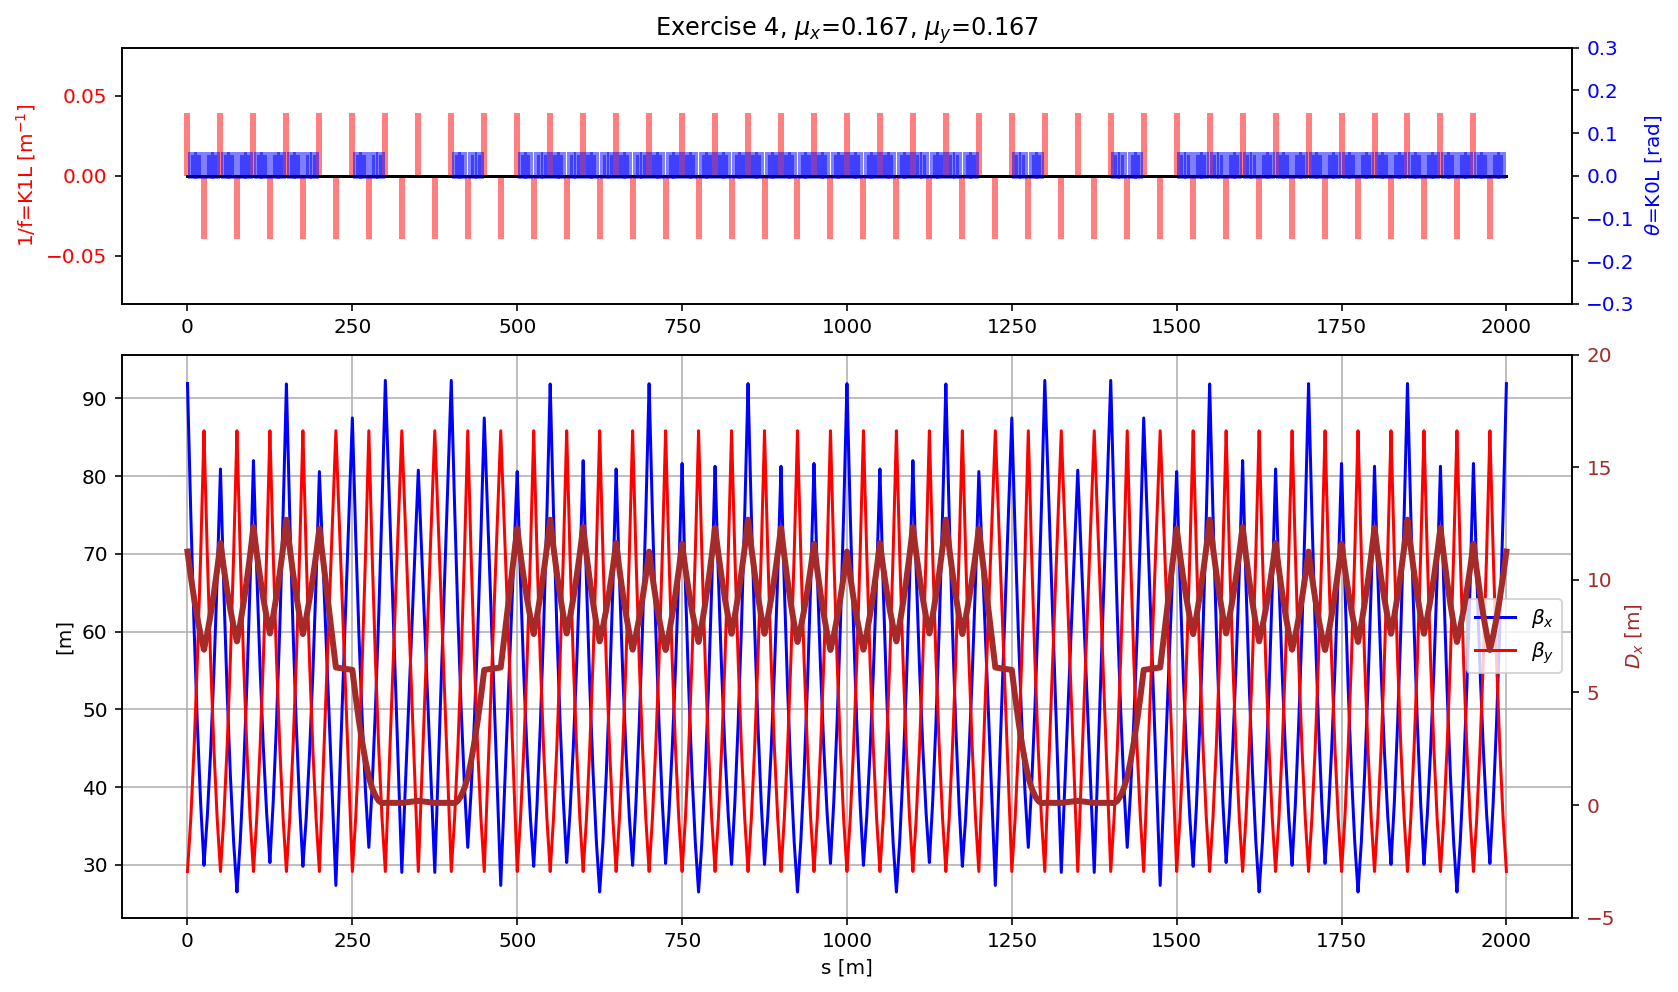

In [29]:
myTwiss=madx.table.twiss.dframe()
fig = plt.figure(figsize=(13,8))

ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.08,.08)
plt.title('Exercise 4, $\\mu_x$='+format(madx.table.summ.Q1[0]/40,'2.3f')+', $\\mu_y$='+ format(madx.table.summ.Q2[0]/40,'2.3f'))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k0l, v_offset=aux.k0l/2, color='b')
    
DF=myTwiss[(myTwiss['keyword']=='sbend')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='b')

plt.ylim(-.3,.3)

# large subplot
plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$', lw=3)
ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(-5, 20)

#### Survey sanity checks

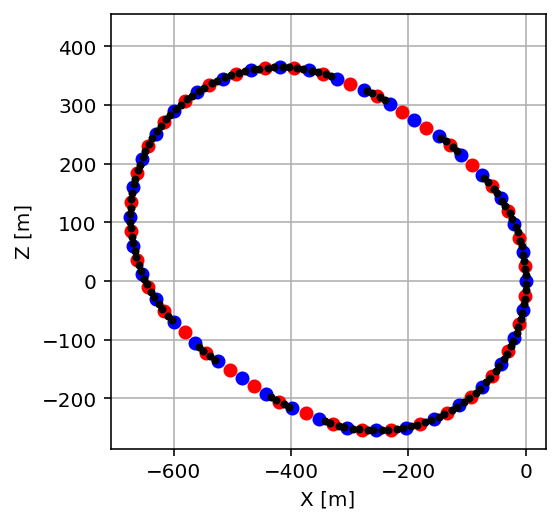

In [13]:
madx.input('survey')
mySurvey=madx.table.survey.dframe()
qfSurvey=mySurvey[mySurvey['name'].str.contains('qf')]
qdSurvey=mySurvey[mySurvey['name'].str.contains('qd')]
mbSurvey=mySurvey[mySurvey['name'].str.contains('mb')]

plt.plot(qfSurvey.x,qfSurvey.z,'ob')
plt.plot(qdSurvey.x,qdSurvey.z,'or')
plt.plot(mbSurvey.x,mbSurvey.z,'.k')

plt.axis('square');
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.grid()

### One can also use the half-dipole topology

In [14]:
madx=Madx(stdout=False)
madx.input('''
TITLE, 'CAS Fourth  Exercise'; 

circum=2000.0;
ncell = 40; !Number of cells 
lcell = circum/ncell;
lq = 3.00; !Length of a quadrupole

nnorm=120;

!element definitions;

!define bending magnet as multipole 
!we have 4 bending magnets per cell

mb:multipole,knl={2.0*pi/(nnorm)};
mb2:multipole,knl={1.0*pi/(nnorm)};

!define quadrupoles as multipoles 

kqf=0.0098;
kqd=-0.0098;
qf: multipole,knl:={0,kqf*lq}; 
qd: multipole,knl:={0,kqd*lq};

// define the sextupoles as multipole
lsex = 0.00001; // dummy length, only used in the sequence; i


ksf := +0.017041/20;
ksd := -0.024714/20;

// ATTENTION: must use knl:= and NOT knl= to match later ! 
msf: multipole, knl:={0,0,ksf};
msd: multipole, knl:={0,0,ksd};


!sequence declaration;
cas4: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
 
   n = 0;
   while (n < 3) {
    qf: qf,   at=n*lcell;
    msf: msf, at=n*lcell + lsex/2.0;
    mb: mb,   at=n*lcell + 0.15*lcell;
    mb: mb,   at=n*lcell + 0.35*lcell;
    qd: qd,   at=n*lcell + 0.50*lcell;
    msd: msd, at=n*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=n*lcell + 0.65*lcell;
    mb: mb,   at=n*lcell + 0.85*lcell;
    n = n + 1;
}

! *************************
! START dispersion suppressor
    while (n<6) {
        qf: qf,     at=n*lcell;
        mb2: mb2,   at=n*lcell + 0.15*lcell;
        mb2: mb2,   at=n*lcell + 0.35*lcell;
        qd: qd,     at=n*lcell + 0.50*lcell;
        mb2: mb2,   at=n*lcell + 0.65*lcell;
        mb2: mb2,   at=n*lcell + 0.85*lcell;
        n = n + 1;
}
! END dispersion suppressor

! *************************
! START straight section
        qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        n = n + 1;

        qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        n = n + 1;
! END straight section

! *************************
! START dispersion suppressor
while (n<11){
        qf: qf,     at=n*lcell;
        mb2: mb2,   at=n*lcell + 0.15*lcell;
        mb2: mb2,   at=n*lcell + 0.35*lcell;
        qd: qd,     at=n*lcell + 0.50*lcell;
        mb2: mb2,   at=n*lcell + 0.65*lcell;
        mb2: mb2,   at=n*lcell + 0.85*lcell;
    n = n + 1;
}
! END dispersion suppressor
   
   while (n < 23) {
    qf: qf,   at=n*lcell;
    msf: msf, at=n*lcell + lsex/2.0;
    mb: mb,   at=n*lcell + 0.15*lcell;
    mb: mb,   at=n*lcell + 0.35*lcell;
    qd: qd,   at=n*lcell + 0.50*lcell;
    msd: msd, at=n*lcell + 0.50*lcell + lsex/2.0;
    mb: mb,   at=n*lcell + 0.65*lcell;
    mb: mb,   at=n*lcell + 0.85*lcell;
    n = n + 1;
}

! *************************
! START dispersion suppressor
   while (n<26){
        qf: qf,     at=n*lcell;
        mb2: mb2,   at=n*lcell + 0.15*lcell;
    mb2: mb2,   at=n*lcell + 0.35*lcell;
        qd: qd,     at=n*lcell + 0.50*lcell;
        mb2: mb2,   at=n*lcell + 0.65*lcell;
        mb2: mb2,   at=n*lcell + 0.85*lcell;
    n = n + 1;
}
! END dispersion suppressor

! *************************
! START straight section
        qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        n = n + 1;

        qf: qf,   at=n*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        n = n + 1;
! END straight section

! *************************
! START dispersion suppressor
   while (n<31){
        qf: qf,     at=n*lcell;
        mb2: mb2,   at=n*lcell + 0.15*lcell;
    mb2: mb2,   at=n*lcell + 0.35*lcell;
        qd: qd,     at=n*lcell + 0.50*lcell;
        mb2: mb2,   at=n*lcell + 0.65*lcell;
        mb2: mb2,   at=n*lcell + 0.85*lcell;
    n = n + 1;
}
! END dispersion suppressor

   while (n < ncell) {
        qf: qf,   at=n*lcell;
        msf: msf, at=n*lcell + lsex/2.0;
        mb: mb,   at=n*lcell + 0.15*lcell;
        mb: mb,   at=n*lcell + 0.35*lcell;
        qd: qd,   at=n*lcell + 0.50*lcell;
        msd: msd, at=n*lcell + 0.50*lcell + lsex/2.0;
        mb: mb,   at=n*lcell + 0.65*lcell;
        mb: mb,   at=n*lcell + 0.85*lcell;
        n = n + 1;
}

end_machine: marker at=circum;
endsequence;

!define the beam and its properties

Beam, particle = proton, sequence=cas4, energy = 20.0;

!define the desired output

use, sequence=cas4;
select,flag=twiss,column=name,s,x,y,mux,betx, muy,bety,dx,dy;

!Tune matching

match, sequence=cas4;
  vary,name=kqf, step=0.00001;
  vary,name=kqd, step=0.00001;
  global,sequence=cas4,Q1=6.7;
  global,sequence=cas4,Q2=6.65;
  Lmdif, calls=10, tolerance=1.0e-21;
endmatch;

! Chromaticity matching
!match, sequence=cas4;
!  vary,name=ksf, step=0.00001;
!  vary,name=ksd, step=0.00001;
!  global,sequence=cascell1,DQ1=0.0;
!  global,sequence=cascell1,DQ2=0.0;
!  Lmdif, calls=10, tolerance=1.0e-21;
!endmatch;

!execute the TWISS command 
twiss;
''');

(-5, 20)

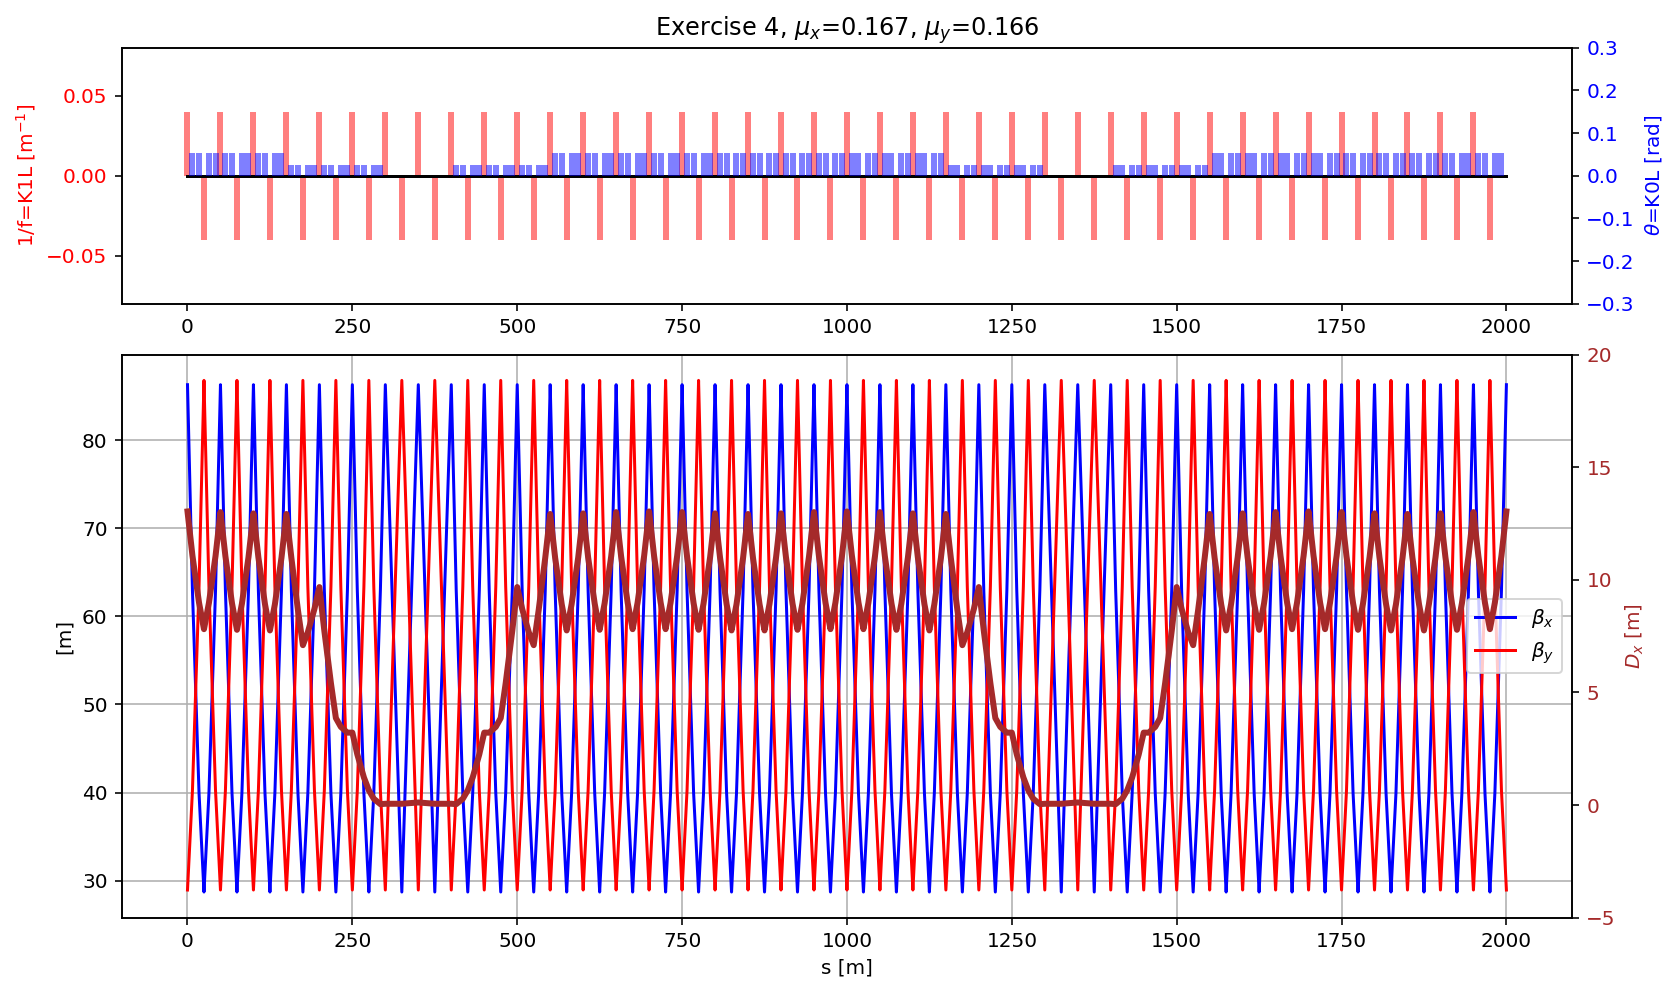

In [31]:
myTwiss=madx.table.twiss.dframe()
fig = plt.figure(figsize=(13,8))

ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')


DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.08,.08)
plt.title('Exercise 4, $\\mu_x$='+format(madx.table.summ.Q1[0]/40,'2.3f')+', $\\mu_y$='+ format(madx.table.summ.Q2[0]/40,'2.3f'))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k0l, v_offset=aux.k0l/2, color='b')
    
DF=myTwiss[(myTwiss['keyword']=='sbend')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='b')

plt.ylim(-.3,.3)

# large subplot
plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx()   # instantiate a second axes that shares the same x-axis
plt.plot(myTwiss['s'],myTwiss['dx'],'brown', label='$D_x$', lw=3)
ax3.set_ylabel('$D_x$ [m]', color='brown')  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(-5, 20)

#### Survey sanity check

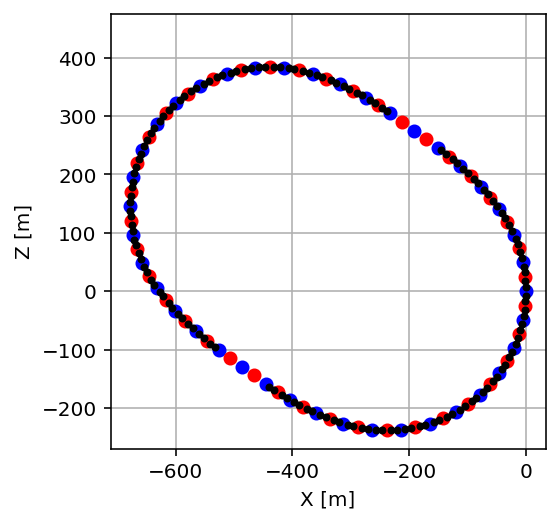

In [15]:
madx.input('survey')
mySurvey=madx.table.survey.dframe()
qfSurvey=mySurvey[mySurvey['name'].str.contains('qf')]
qdSurvey=mySurvey[mySurvey['name'].str.contains('qd')]
mbSurvey=mySurvey[mySurvey['name'].str.contains('mb')]

plt.plot(qfSurvey.x,qfSurvey.z,'ob')
plt.plot(qdSurvey.x,qdSurvey.z,'or')
plt.plot(mbSurvey.x,mbSurvey.z,'.k')

plt.axis('square');
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.grid()